# *Import*

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import cv2
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from keras import layers
import seaborn as sn
from keras.models import Sequential
# Instead of importing directly from keras.preprocessing.image,
# import ImageDataGenerator from tensorflow.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras import datasets, layers, models
from keras.regularizers import l2
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D,BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout,GlobalAveragePooling2D,concatenate
from keras.initializers import random_uniform, glorot_uniform
from keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import cross_val_score, KFold

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.087137716000029
GPU (s):
0.11639061899995795
GPU speedup over CPU: 43x


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# *Preprocessing*

## Categorizing

In [ ]:
pics = []
labels = []
max_height = -1
max_width = -1
#convert = {'Sunrise':0,'Cloudy':1,'Shine':2,'Rain':3}
path = '/content/drive/MyDrive/Multi-class Weather Dataset'
print(os.listdir(path))
for i in os.listdir(path):
  for j in os.listdir(path+'/'+i):
    pic = cv2.imread(path+'/'+i+'/'+j)
    if pic is not None:
      pics.append(pic)
      if i == "Cloudy":
        labels.append(0)
      if i == "Rain":
        labels.append(1)
      if i == "Shine":
          labels.append(2)
      if i == "Sunrise":
        labels.append(3)
      max_height = max(max_height, pic.shape[0])
      max_width = max(max_width, pic.shape[1])


['Rain', 'Cloudy', 'Sunrise', 'Shine']


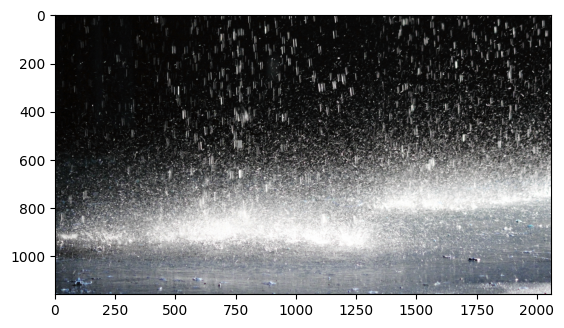

(1158, 2059, 3)
<class 'list'>
<class 'numpy.ndarray'>


In [ ]:
pic = pics[10]
pyplot.imshow(pic,cmap=pyplot.get_cmap('gray'))
pyplot.show()
print(pic.shape)
print(type(pics))
print(type(pic))

## Resize all pics

In [ ]:
for i in range(len(pics)):
  pics[i] = resize(pics[i],(200, 200)) #resizing pictures to 200*200

## Labeling data

In [ ]:
label = np.zeros((len(labels), 4))
for i in range(len(labels)):
  label[i][labels[i]] = 1

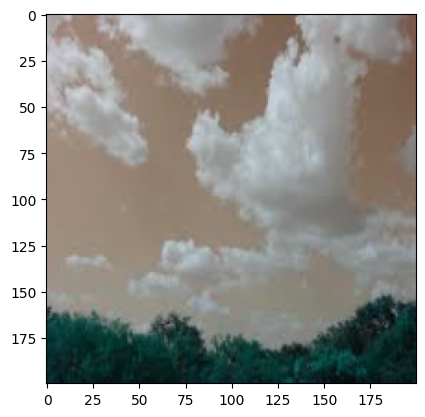

array([1., 0., 0., 0.])

In [ ]:
pyplot.imshow(pics[500],cmap=pyplot.get_cmap('gray'))
pyplot.show()
label[500]

## Report function

In [ ]:
def report(history, model, X_train, X_test, y_train, y_test, epoch = 50):
  #plotting train and validation loss
  loss_train = history.history['loss']
  loss_val = history.history['val_loss']
  epochs = range(0,epoch)
  plt.plot(epochs,loss_train,'g',label='Training loss')
  plt.plot(epochs,loss_val,'b',label='Validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print()
  #plotting train and validation accuracy
  acc_train = history.history['accuracy']
  acc_val = history.history['val_accuracy']
  epochs = range(0,epoch)
  plt.plot(epochs,acc_train,'r',label='Training accuracy')
  plt.plot(epochs,acc_val,'y',label='Validation accuarcy')
  plt.title('Training and Validation accuarcy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuarcy')
  plt.legend()
  plt.show()
  print()
  #printing report for train and validation
  print("Train report")
  y_pred = model.predict(X_train)
  y_pred_label=np.argmax(y_pred,axis=1)
  y_train_clf = np.argmax(y_train,axis=1)
  print(classification_report(y_train_clf, y_pred_label))
  print()
  print()
  print("test report")
  y_pred = model.predict(X_test)
  y_pred_label=np.argmax(y_pred,axis=1)
  y_train_clf = np.argmax(y_test,axis=1)
  print(classification_report(y_train_clf, y_pred_label))

## Confusion matrix

In [ ]:
#confusion matrix function
def Confusion(model, X_train, X_test, y_train, y_test):
  print("Train report")
  y_pred = model.predict(X_train)
  y_pred_label=np.argmax(y_pred,axis=1)
  y_train_clf = np.argmax(y_train,axis=1)
  print(classification_report(y_train_clf, y_pred_label))
  print()
  print()
  print("test report")
  y_pred = model.predict(X_test)
  y_pred_label=np.argmax(y_pred,axis=1)
  y_train_clf = np.argmax(y_test,axis=1)
  print(classification_report(y_train_clf, y_pred_label))
  print()

## Report function (Inception)

In [ ]:
#report function for inception model
def report_inc(history, model, X_train, X_test, y_train, y_test):
  #plotting train and validation loss for inception model
  loss_train = history.history['output_loss']
  loss_val = history.history['val_output_loss']
  epochs = range(0,50)
  plt.plot(epochs,loss_train,'g',label='Training loss')
  plt.plot(epochs,loss_val,'b',label='Validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
  print()
  #plotting train and validation accuracy for inception model
  acc_train = history.history['output_accuracy']
  acc_val = history.history['val_output_accuracy']
  epochs = range(0,50)
  plt.plot(epochs,acc_train,'r',label='Training accuracy')
  plt.plot(epochs,acc_val,'y',label='Validation accuarcy')
  plt.title('Training and Validation accuarcy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuarcy')
  plt.legend()
  plt.show()
  print()
  #train and validation report for train and validation for inception model
  print("Train report")
  y_pred = model.predict(X_train)
  y_pred_label=np.argmax(y_pred[2],axis=1)
  y_train_clf = np.argmax(y_train,axis=1)
  print(classification_report(y_train_clf, y_pred_label))
  print()
  print()
  print("test report")
  y_pred = model.predict(X_test)
  y_pred_label=np.argmax(y_pred[2],axis=1)
  y_train_clf = np.argmax(y_test,axis=1)
  print(classification_report(y_train_clf, y_pred_label))

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,

    validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(200 , 200),
    batch_size = 1,
    class_mode='categorical',
    subset='training')
valid_generator = train_datagen.flow_from_directory(
    path,
    batch_size = 1,
    target_size=(200, 200),
    class_mode='categorical',
    subset='validation')

Found 901 images belonging to 4 classes.
Found 224 images belonging to 4 classes.


In [ ]:
type(train_generator)

keras.src.legacy.preprocessing.image.DirectoryIterator

In [ ]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 30
)

x_t, y_t = next(generator.flow_from_directory(path, batch_size=1))

Found 1125 images belonging to 4 classes.


In [ ]:
print(os.listdir(path))

['Rain', 'Cloudy', 'Sunrise', 'Shine']


In [ ]:
print(len(pics))

1123


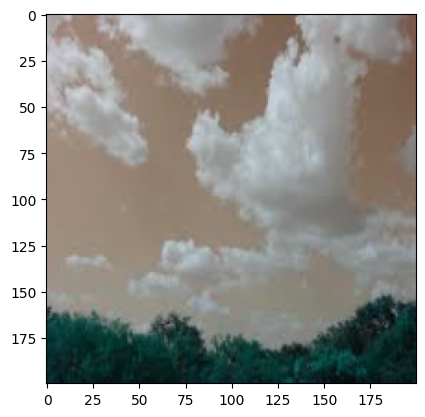

(200, 200, 3)


array([1., 0., 0., 0.])

In [ ]:
pic = pics[500]
pyplot.imshow(pic,cmap=pyplot.get_cmap('gray'))
pyplot.show()
print(pic.shape)
label[500]

## Split data to train and test

In [ ]:
#spliting data to train and val (80%->train, 20%->val)
X_train, X_test, y_train, y_test = train_test_split(pics, label, test_size=0.2, random_state=42)
X_train=np.array(X_train)
X_test=np.array(X_test)
X_train=X_train/255.0
X_test=X_test/255.0
print(X_train.shape)

(898, 200, 200, 3)


## Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(200, 200),
  layers.Rescaling(1./255)
])

# *Fully connected version*

## 3 Hidden layers

In [ ]:
m1 = models.Sequential([
        layers.Flatten(input_shape=(200,200,3)),
        layers.Dense(50, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(10, activation='relu'),
        layers.Dense(4, activation='softmax') #using softmax as activation function for the output layer
    ])
opt = keras.optimizers.Adam(learning_rate=0.001) #using adam optimizer with 0.001 learning rate
m1.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
#printing summary of the model
m1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 120000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │       6,000,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │             310 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │              44 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,001,934 (22.90 MB)

 Trainable params: 6,001,934 (22.90 MB)

 Non-trainable params: 0 (0.00 B)

### Compile

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'): #using gpu
  history = m1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 0.3566 - loss: 1.3099 - val_accuracy: 0.6667 - val_loss: 0.9707
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6753 - loss: 0.9457 - val_accuracy: 0.7422 - val_loss: 0.7078
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7684 - loss: 0.7380 - val_accuracy: 0.7911 - val_loss: 0.6065
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8117 - loss: 0.6063 - val_accuracy: 0.7956 - val_loss: 0.5713
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8021 - loss: 0.6170 - val_accuracy: 0.7956 - val_loss: 0.5450
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7960 - loss: 0.5989 - val_accuracy: 0.7956 - val_loss: 0.5420
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7976 - loss: 0.5564 - val_accuracy: 0.8000 - val_loss: 0.5202
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7990 - loss: 0.5525 - val_accuracy: 0.7778 - 

### Report

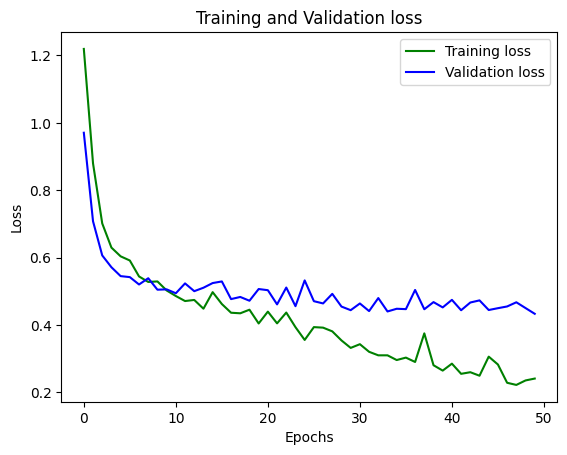

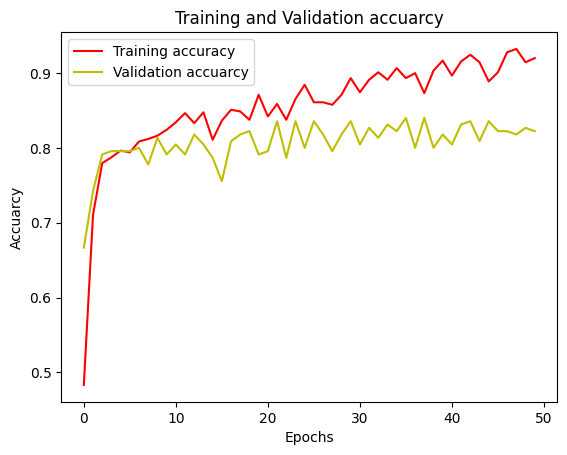


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       240
           1       0.88      0.91      0.89       169
           2       0.92      0.98      0.95       210
           3       0.99      0.99      0.99       279

    accuracy                           0.94       898
   macro avg       0.93      0.93      0.93       898
weighted avg       0.94      0.94      0.93       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
              precision    recall  f1-score   support

           0       0.71      0.73      0.72        60
           1       0.72      0.69      0.70        45
           2       0.82      0.79      0.80        42
           3       0.96      0.99      0.97        78

    accuracy                           0.82       225
   macro avg       0.80      0.80      0.80       225
weighted avg       0.82      0.82      0.82       225



In [ ]:
report(history, m1, X_train, X_test, y_train, y_test)

## 5 Hidden layers

In [ ]:
m1 = models.Sequential([
        layers.Flatten(input_shape=(200,200,3)),
        layers.Dense(50, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(40, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(30, activation='relu'),
        layers.Dense(4, activation='softmax')   #using softmax as activation function for the output layer
    ])
opt = keras.optimizers.Adam(learning_rate=0.001)
m1.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
m1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 120000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │       6,000,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 40)                  │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,005,104 (22.91 MB)

 Trainable params: 6,005,104 (22.91 MB)

 Non-trainable params: 0 (0.00 B)

### Compile

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = m1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 249ms/step - accuracy: 0.4811 - loss: 1.2796 - val_accuracy: 0.5378 - val_loss: 0.9585
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5780 - loss: 0.9447 - val_accuracy: 0.7511 - val_loss: 0.6636
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7297 - loss: 0.7073 - val_accuracy: 0.7244 - val_loss: 0.5979
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7997 - loss: 0.5634 - val_accuracy: 0.7644 - val_loss: 0.5368
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8001 - loss: 0.5834 - val_accuracy: 0.7644 - val_loss: 0.6004
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8021 - loss: 0.5398 - val_accuracy: 0.7867 - val_loss: 0.5246
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8270 - loss: 0.4921 - val_accuracy: 0.7911 - val_loss: 0.5106
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8087 - loss: 0.4499 - val_accuracy: 0.8133 

### Report

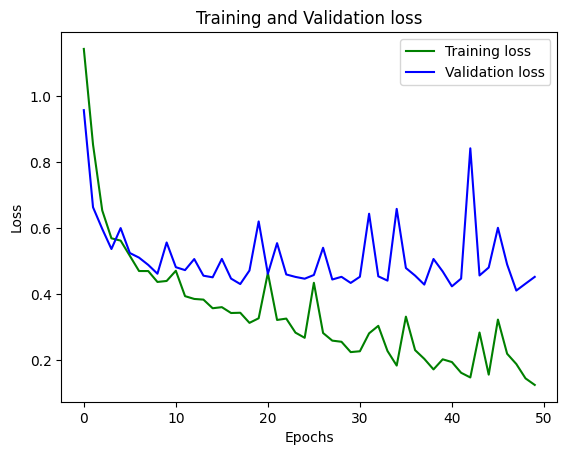

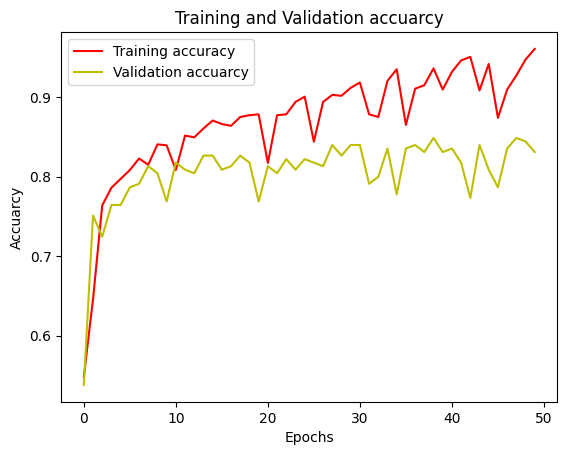


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

           0       0.97      0.88      0.92       240
           1       0.86      0.98      0.92       169
           2       0.98      0.98      0.98       210
           3       1.00      1.00      1.00       279

    accuracy                           0.96       898
   macro avg       0.95      0.96      0.95       898
weighted avg       0.96      0.96      0.96       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        60
           1       0.68      0.76      0.72        45
           2       0.87      0.81      0.84        42
           3       0.99      1.00      0.99        78

    accuracy                           0.83       225
   macro avg       0.81      0.81      0.81       225
weighted avg       0.83      0.83      0.83       225



In [ ]:
report(history, m1, X_train, X_test, y_train, y_test)

## 7 Hidden layers

In [ ]:
model = models.Sequential([
        layers.Flatten(input_shape=(200,200,3)),
        layers.Dense(50, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        BatchNormalization(),
        layers.Dense(30, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        BatchNormalization(),
        layers.Dense(40, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        BatchNormalization(),
        layers.Dense(30, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        BatchNormalization(),
        layers.Dense(30, activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        layers.Dense(4, activation='softmax')    #using softmax as activation function for the output layer
    ])
opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 120000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 50)                  │       6,000,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30)                  │             120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 40)                  │           1,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 40)                  │             160 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 30)                  │             120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 4)                   │             124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,005,704 (22.91 MB)

 Trainable params: 6,005,404 (22.91 MB)

 Non-trainable params: 300 (1.17 KB)

### Compile

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = m1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9492 - loss: 0.1263 - val_accuracy: 0.7911 - val_loss: 0.7607
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9124 - loss: 0.2558 - val_accuracy: 0.8178 - val_loss: 0.5007
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9491 - loss: 0.1347 - val_accuracy: 0.8356 - val_loss: 0.4954
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9722 - loss: 0.0976 - val_accuracy: 0.8133 - val_loss: 0.6511
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9403 - loss: 0.1583 - val_accuracy: 0.7778 - val_loss: 0.7622
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9157 - loss: 0.1987 - val_accuracy: 0.8311 - val_loss: 0.4652
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9767 - loss: 0.0783 - val_accuracy: 0.8489 - val_loss: 0.4837
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9190 - loss: 0.1794 - val_accuracy: 0.8444 - v

### Report

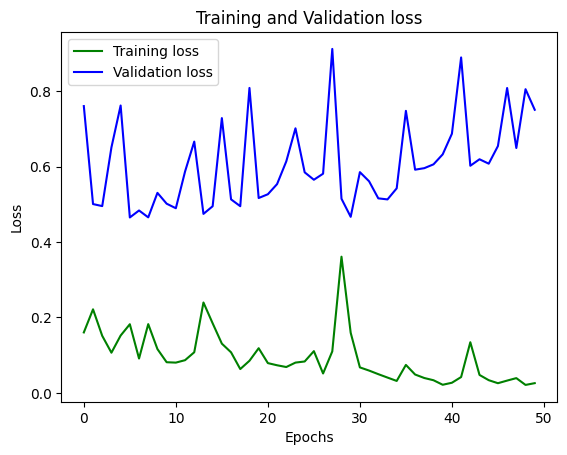

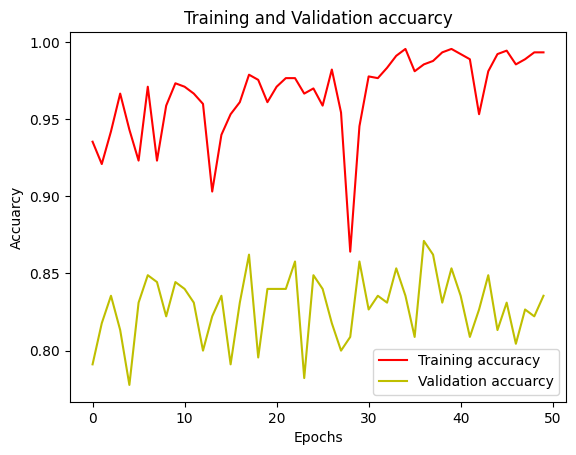


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      0.99      1.00       169
           2       1.00      1.00      1.00       210
           3       1.00      1.00      1.00       279

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        60
           1       0.78      0.56      0.65        45
           2       0.88      0.83      0.85        42
           3       0.99      1.00      0.99        78

    accuracy                           0.84       225
   macro avg       0.83      0.81      0.81       225
weighted avg       0.84      0.84      0.83       225



In [ ]:
report(history, m1, X_train, X_test, y_train, y_test)

# *Fully connected (Drop out)*

## First model

In [ ]:
model = models.Sequential([
        layers.Flatten(input_shape=(200,200,3)),
        layers.Dense(100, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.4),
        layers.Dense(80, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.4),
        layers.Dense(80, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.6),
        layers.Dense(60, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.6),
        layers.Dense(60, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.7),
        layers.Dense(50, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.7),
        layers.Dense(50, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.7),
        layers.Dense(30, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        Dropout(0.7),
        layers.Dense(30, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        layers.Dense(4, activation='softmax')  #using softmax as activation function for the output layer
    ])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)                  │ (None, 120000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 100)                 │      12,000,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 80)                  │           8,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 80)                  │           6,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 80)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 60)                  │           4,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 60)                  │           3,660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 50)                  │           3,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 50)                  │           2,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 30)                  │           1,530 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 30)                  │             930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 4)                   │             124 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,031,364 (45.90 MB)

 Trainable params: 12,031,364 (45.90 MB)

 Non-trainable params: 0 (0.00 B)

### Compile

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = m1.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9937 - loss: 0.0172 - val_accuracy: 0.8356 - val_loss: 0.7532
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9998 - loss: 0.0111 - val_accuracy: 0.8444 - val_loss: 0.6843
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9992 - loss: 0.0083 - val_accuracy: 0.8400 - val_loss: 0.7761
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9948 - loss: 0.0207 - val_accuracy: 0.8444 - val_loss: 0.7317
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9962 - loss: 0.0176 - val_accuracy: 0.8533 - val_loss: 0.7081
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9988 - loss: 0.0110 - val_accuracy: 0.8667 - val_loss: 0.7189
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9998 - loss: 0.0057 - val_accuracy: 0.8400 - val_loss: 0.7302
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9988 - loss: 0.0112 - val_accuracy: 0.8311 - v

### Report

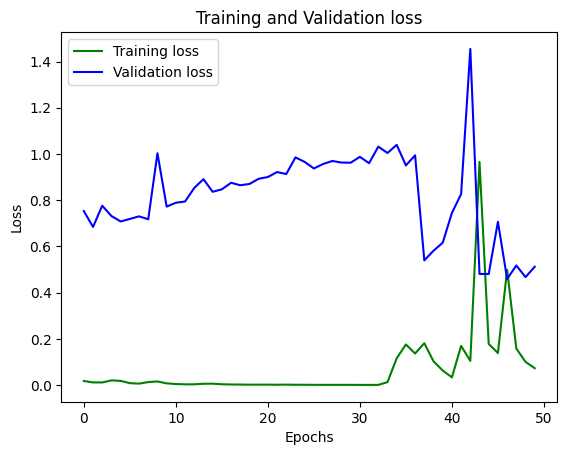

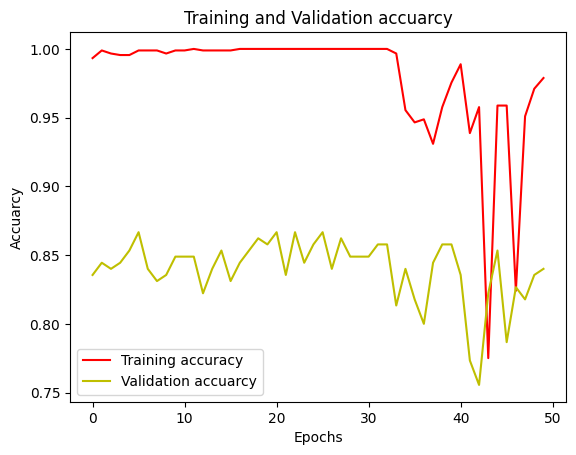


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       240
           1       0.96      1.00      0.98       169
           2       0.99      0.98      0.99       210
           3       0.99      1.00      1.00       279

    accuracy                           0.99       898
   macro avg       0.98      0.99      0.98       898
weighted avg       0.99      0.99      0.99       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
              precision    recall  f1-score   support

           0       0.72      0.73      0.73        60
           1       0.71      0.80      0.75        45
           2       0.91      0.74      0.82        42
           3       0.99      1.00      0.99        78

    accuracy                           0.84       225
   macro avg       0.83      0.82      0.82       225
weighted avg       0.85      0.84      0.84       225



In [ ]:
report(history, m1, X_train, X_test, y_train, y_test)

# *CNN*

## First model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           strides=(4,4), activation='relu',
                           input_shape=(200,200,3)),
    Dropout(0.6),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           strides=(2,2), activation='relu',
                           padding="same"),
    Dropout(0.6),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           strides=(1,1), activation='relu',
                           padding="same"),
    Dropout(0.6),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')  #using softmax as activation function for the output layer
])
opt = keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 48, 48, 11)          │           4,004 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 48, 48, 11)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 24, 24, 11)          │           3,036 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 24, 24, 11)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 24, 24, 11)          │           1,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 24, 24, 11)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 6336)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 200)                 │       1,267,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 4)                   │             804 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,276,344 (4.87 MB)

 Trainable params: 1,276,344 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

### Compile

In [ ]:

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step - accuracy: 0.2813 - loss: 1.3828 - val_accuracy: 0.3467 - val_loss: 1.3160
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4383 - loss: 1.2121 - val_accuracy: 0.5822 - val_loss: 0.9114
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5588 - loss: 0.9834 - val_accuracy: 0.6133 - val_loss: 0.8289
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6712 - loss: 0.8260 - val_accuracy: 0.6000 - val_loss: 0.8928
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6530 - loss: 0.8232 - val_accuracy: 0.7422 - val_loss: 0.5634
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6839 - loss: 0.7816 - val_accuracy: 0.4178 - val_loss: 1.7253
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7259 - loss: 0.7514 - val_accuracy: 0.7289 - val_loss: 0.7039
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7237 - loss: 0.7242 - val_accuracy: 0.7289 -

### Report

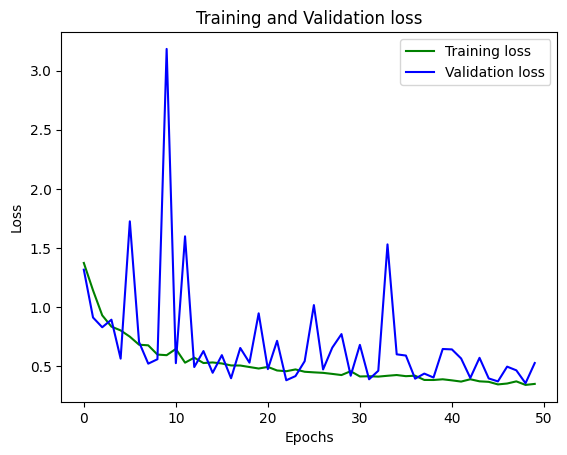

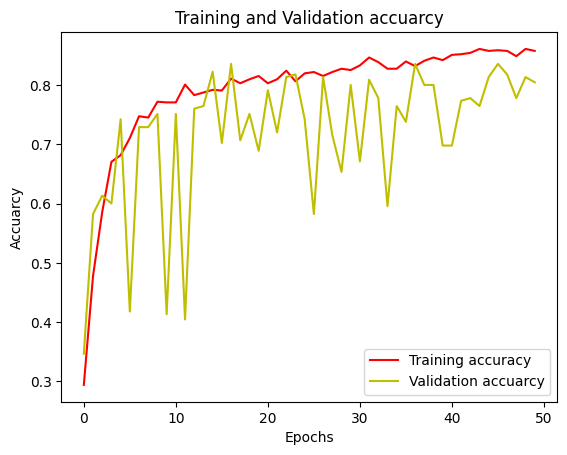


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
              precision    recall  f1-score   support

           0       0.77      0.80      0.79       240
           1       0.73      0.84      0.78       169
           2       0.93      0.77      0.84       210
           3       0.99      0.98      0.98       279

    accuracy                           0.86       898
   macro avg       0.85      0.85      0.85       898
weighted avg       0.87      0.86      0.86       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
              precision    recall  f1-score   support

           0       0.68      0.60      0.64        60
           1       0.59      0.82      0.69        45
           2       0.97      0.76      0.85        42
           3       1.00      0.97      0.99        78

    accuracy                           0.80       225
   macro avg       0.81      0.79      0.79       225
weighted avg       0.83      0.80      0.81       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 



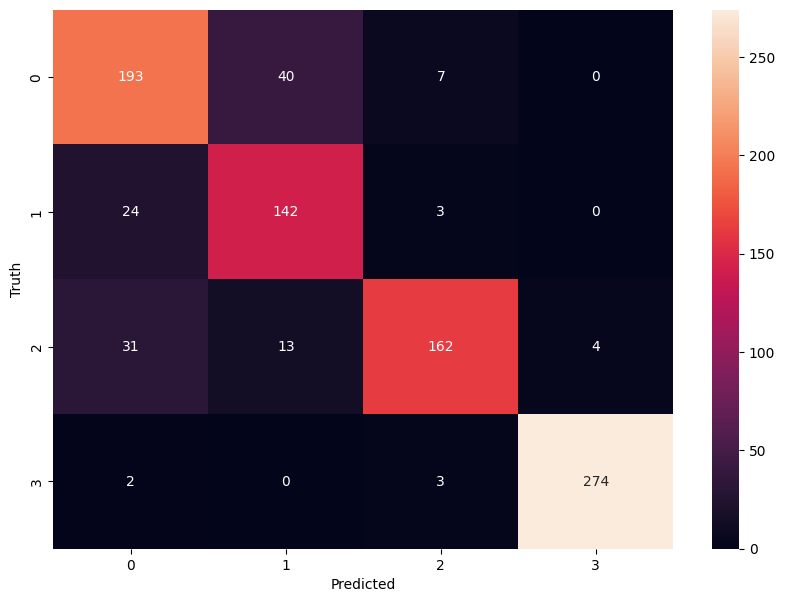

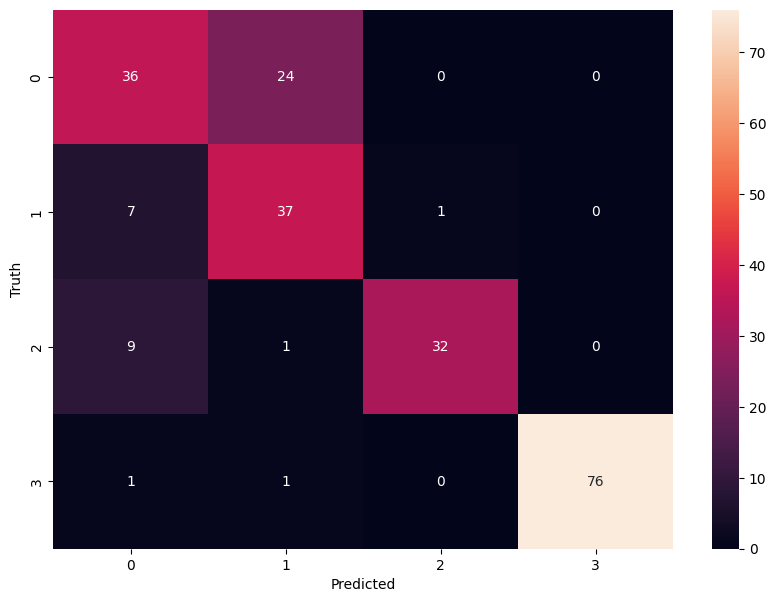

In [ ]:
y_predicted_train = model.predict(X_train)
y_predicted_labels_train = [np.argmax(i) for i in y_predicted_train]
y_train_clf = np.argmax(y_train,axis=1)
cm = tf.math.confusion_matrix(labels=y_train_clf,predictions=y_predicted_labels_train)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')




y_predicted = model.predict(X_test)
y_predicted_labels = [np.argmax(i) for i in y_predicted]
y_test_clf = np.argmax(y_test,axis=1)
cm = tf.math.confusion_matrix(labels=y_test_clf,predictions=y_predicted_labels)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
print()


## Second model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           strides=(4,4), activation='relu',
                           input_shape=(200,200,3)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           strides=(2,2), activation='relu',
                           padding="same"),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           strides=(1,1), activation='relu',
                           padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dense(200,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')  #using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)                   │ (None, 48, 48, 11)          │           4,004 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 24, 24, 11)          │           3,036 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 24, 24, 11)          │           1,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 6336)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 200)                 │       1,267,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 200)                 │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 4)                   │             804 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,316,544 (5.02 MB)

 Trainable params: 1,316,544 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

### Compile

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.2835 - loss: 1.3828 - val_accuracy: 0.3467 - val_loss: 1.3638
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3188 - loss: 1.3722 - val_accuracy: 0.3467 - val_loss: 1.3585
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3203 - loss: 1.3409 - val_accuracy: 0.3467 - val_loss: 1.0996
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4161 - loss: 1.0720 - val_accuracy: 0.6222 - val_loss: 0.8881
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5603 - loss: 0.9674 - val_accuracy: 0.6267 - val_loss: 0.7613
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5854 - loss: 0.8345 - val_accuracy: 0.6267 - val_loss: 0.7880
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6090 - loss: 0.8498 - val_accuracy: 0.6356 - val_loss: 0.7492
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6393 - loss: 0.7534 - val_accuracy: 0.6622 - 

### Report

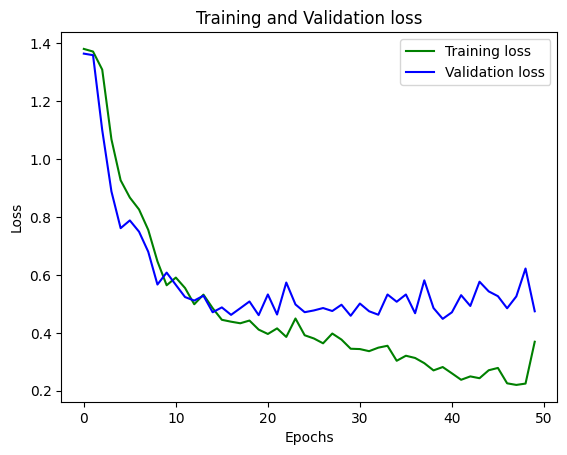

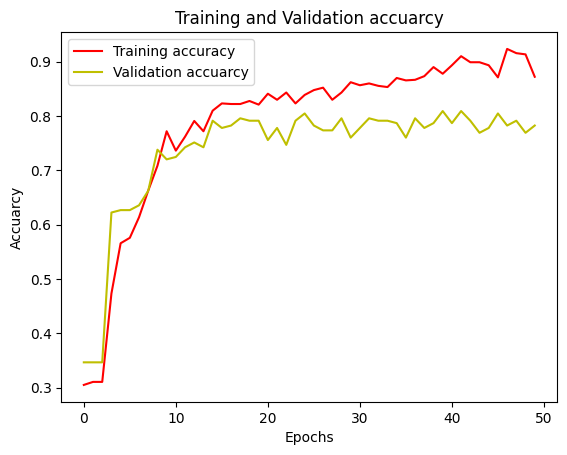


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       240
           1       0.91      0.76      0.83       169
           2       0.96      0.97      0.96       210
           3       0.98      1.00      0.99       279

    accuracy                           0.92       898
   macro avg       0.92      0.91      0.91       898
weighted avg       0.92      0.92      0.92       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
              precision    recall  f1-score   support

           0       0.63      0.68      0.66        60
           1       0.63      0.58      0.60        45
           2       0.80      0.76      0.78        42
           3       0.97      0.99      0.98        78

    accuracy                           0.78       225
   macro avg       0.76      0.75      0.76       225
weighted avg       0.78      0.78      0.78       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test)

## Third model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                           strides=(2,2), activation='relu',
                           input_shape=(200,200,3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=5,
                           strides=(3,3), activation='relu',
                           padding="valid"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=5,
                           strides=(4,4), activation='relu',
                           padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')#using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)                   │ (None, 98, 98, 16)          │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 32, 32, 32)          │          12,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 7, 7, 64)            │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 483,876 (1.85 MB)

 Trainable params: 483,876 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

### Compile

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 0.2878 - loss: 1.3852 - val_accuracy: 0.3467 - val_loss: 1.3759
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.3180 - loss: 1.3719 - val_accuracy: 0.4444 - val_loss: 1.3330
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4452 - loss: 1.3207 - val_accuracy: 0.3644 - val_loss: 1.2112
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.4927 - loss: 1.1844 - val_accuracy: 0.6933 - val_loss: 1.0119
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6344 - loss: 1.0260 - val_accuracy: 0.5644 - val_loss: 0.9008
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6497 - loss: 0.8761 - val_accuracy: 0.7156 - val_loss: 0.7421
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6956 - loss: 0.7934 - val_accuracy: 0.7022 - val_loss: 0.6868
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6963 - loss: 0.6968 - val_accuracy: 0.7200 -

### Report

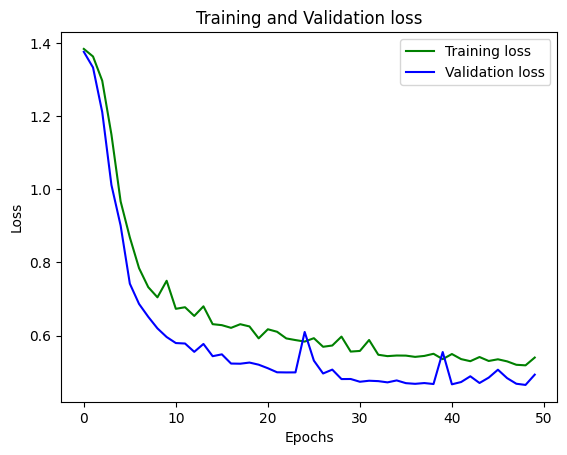

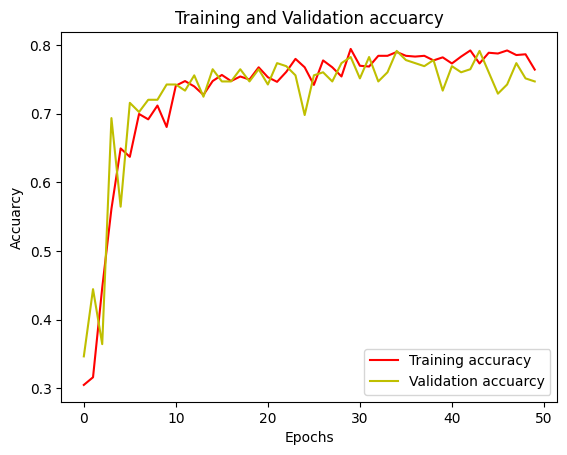


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              precision    recall  f1-score   support

           0       0.67      0.54      0.60       240
           1       0.58      0.75      0.65       169
           2       0.85      0.82      0.83       210
           3       0.92      0.95      0.93       279

    accuracy                           0.77       898
   macro avg       0.76      0.76      0.75       898
weighted avg       0.77      0.77      0.77       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
              precision    recall  f1-score   support

           0       0.60      0.40      0.48        60
           1       0.53      0.76      0.62        45
           2       0.82      0.76      0.79        42
           3       0.95      1.00      0.97        78

    accuracy                           0.75       225
   macro avg       0.73      0.73      0.72       225
weighted avg       0.75      0.75      0.74       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test)

# *CNN (Max pooling)*

## First model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')  #using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)                   │ (None, 200, 200, 11)        │           4,004 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 200, 200, 11)        │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 11)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 96, 96, 11)          │           3,036 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 96, 96, 11)          │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 48, 48, 11)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 24, 24, 11)          │           1,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 24, 24, 11)          │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 11)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 1584)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 100)                 │         158,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 4)                   │             404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 177,276 (692.48 KB)

 Trainable params: 177,210 (692.23 KB)

 Non-trainable params: 66 (264.00 B)

### Compile

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 240ms/step - accuracy: 0.5471 - loss: 1.1049 - val_accuracy: 0.2000 - val_loss: 1.3969
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8515 - loss: 0.4282 - val_accuracy: 0.2667 - val_loss: 1.5435
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8355 - loss: 0.3775 - val_accuracy: 0.2667 - val_loss: 1.7058
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9208 - loss: 0.2190 - val_accuracy: 0.2667 - val_loss: 1.9243
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9290 - loss: 0.1899 - val_accuracy: 0.2000 - val_loss: 2.3122
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9419 - loss: 0.1474 - val_accuracy: 0.2667 - val_loss: 2.5511
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9717 - loss: 0.0919 - val_accuracy: 0.2667 - val_loss: 2.7911
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9705 - loss: 0.0950 - val_accuracy: 0.2044 -

### Report

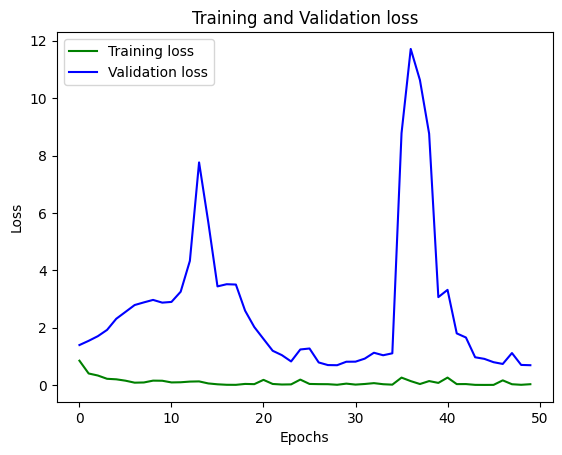

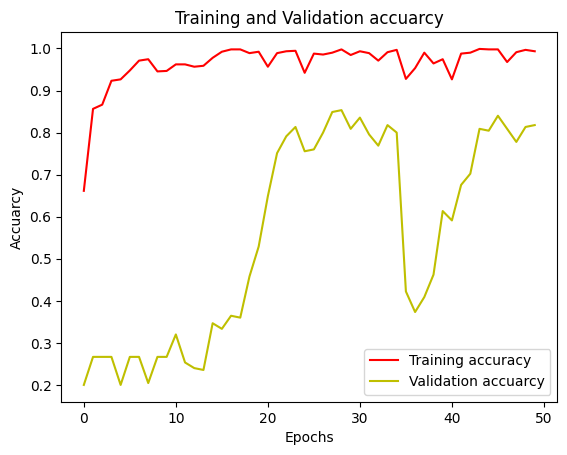


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       240
           1       0.99      0.99      0.99       169
           2       0.91      1.00      0.95       210
           3       1.00      1.00      1.00       279

    accuracy                           0.97       898
   macro avg       0.97      0.97      0.97       898
weighted avg       0.97      0.97      0.97       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
              precision    recall  f1-score   support

           0       0.79      0.62      0.69        60
           1       0.77      0.73      0.75        45
           2       0.66      0.90      0.76        42
           3       0.99      0.97      0.98        78

    accuracy                           0.82       225
   macro avg       0.80      0.81      0.80       225
weighted avg       0.83      0.82      0.82       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test)

## Second model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150,activation='relu'),
    tf.keras.layers.Dense(150,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')  #using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_34 (Conv2D)                   │ (None, 200, 200, 11)        │           4,004 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 200, 200, 11)        │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 99, 99, 11)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 50, 50, 11)          │           3,036 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 50, 50, 11)          │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 11)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_36 (Conv2D)                   │ (None, 8, 8, 11)            │           1,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 8, 8, 11)            │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 11)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 44)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 150)                 │           6,750 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_38 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_39 (Dense)                     │ (None, 4)                   │             604 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,276 (149.52 KB)

 Trainable params: 38,210 (149.26 KB)

 Non-trainable params: 66 (264.00 B)

### Compile

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=50)

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 232ms/step - accuracy: 0.6049 - loss: 0.8997 - val_accuracy: 0.2000 - val_loss: 1.3933
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.7957 - loss: 0.5251 - val_accuracy: 0.2000 - val_loss: 1.4216
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8351 - loss: 0.4280 - val_accuracy: 0.2000 - val_loss: 1.4777
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8438 - loss: 0.4333 - val_accuracy: 0.2000 - val_loss: 1.5656
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8633 - loss: 0.3717 - val_accuracy: 0.2000 - val_loss: 1.6746
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8685 - loss: 0.3337 - val_accuracy: 0.2000 - val_loss: 1.7728
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8707 - loss: 0.3473 - val_accuracy: 0.2000 - val_loss: 2.0582
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9073 - loss: 0.2709 - val_accuracy: 0.2000 -

### Report

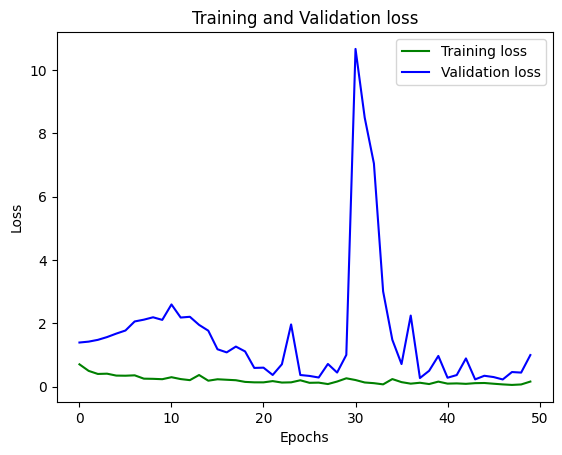

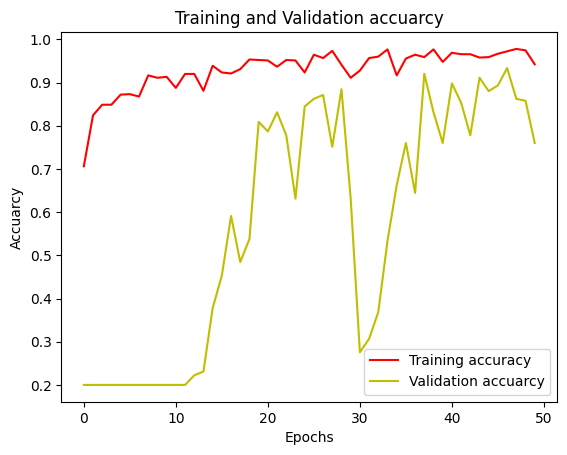


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
              precision    recall  f1-score   support

           0       0.96      0.21      0.34       240
           1       0.50      1.00      0.67       169
           2       0.85      0.97      0.91       210
           3       1.00      0.96      0.98       279

    accuracy                           0.77       898
   macro avg       0.83      0.78      0.72       898
weighted avg       0.86      0.77      0.73       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
              precision    recall  f1-score   support

           0       0.93      0.22      0.35        60
           1       0.48      0.96      0.64        45
           2       0.84      0.90      0.87        42
           3       1.00      0.99      0.99        78

    accuracy                           0.76       225
   macro avg       0.81      0.77      0.72       225
weighted avg       0.85      0.76      0.73       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test)

# *CNN (AVG pooling)*

## First model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), padding='same'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax') #using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_37 (Conv2D)                   │ (None, 200, 200, 11)        │           4,004 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 200, 200, 11)        │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d (AveragePooling2D) │ (None, 100, 100, 11)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 50, 50, 11)          │           3,036 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 50, 50, 11)          │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 25, 25, 11)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 13, 13, 11)          │           1,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 13, 13, 11)          │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 6, 6, 11)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 396)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 100)                 │          39,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 4)                   │             404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,476 (228.42 KB)

 Trainable params: 58,410 (228.16 KB)

 Non-trainable params: 66 (264.00 B)

### Compile

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=80)

Epoch 1/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 197ms/step - accuracy: 0.5068 - loss: 1.0829 - val_accuracy: 0.2667 - val_loss: 1.4048
Epoch 2/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8242 - loss: 0.4724 - val_accuracy: 0.2667 - val_loss: 1.7679
Epoch 3/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8349 - loss: 0.4064 - val_accuracy: 0.2667 - val_loss: 2.1824
Epoch 4/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8806 - loss: 0.3224 - val_accuracy: 0.2667 - val_loss: 2.8580
Epoch 5/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9116 - loss: 0.2734 - val_accuracy: 0.2667 - val_loss: 3.4403
Epoch 6/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9010 - loss: 0.2624 - val_accuracy: 0.2667 - val_loss: 3.8475
Epoch 7/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9171 - loss: 0.2220 - val_accuracy: 0.2622 - val_loss: 4.5374
Epoch 8/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9492 - loss: 0.1613 - val_accuracy: 0.3067 -

### Report

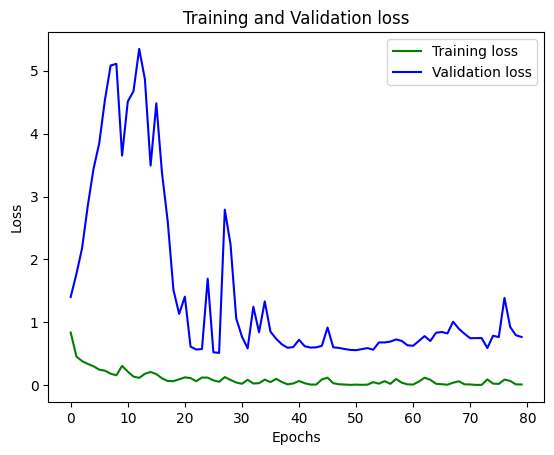

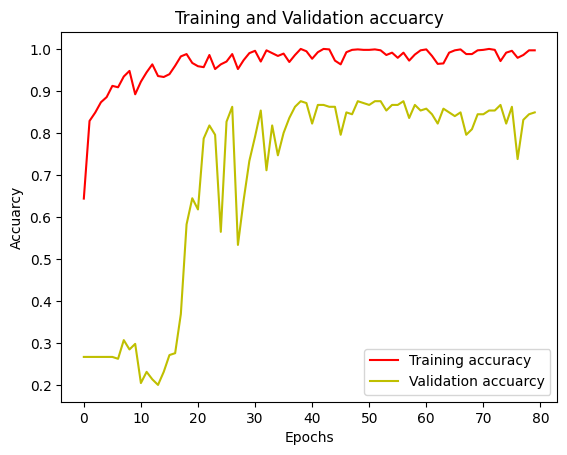


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       240
           1       1.00      1.00      1.00       169
           2       1.00      1.00      1.00       210
           3       1.00      1.00      1.00       279

    accuracy                           1.00       898
   macro avg       1.00      1.00      1.00       898
weighted avg       1.00      1.00      1.00       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
              precision    recall  f1-score   support

           0       0.80      0.68      0.74        60
           1       0.69      0.76      0.72        45
           2       0.85      0.93      0.89        42
           3       0.97      0.99      0.98        78

    accuracy                           0.85       225
   macro avg       0.83      0.84      0.83       225
weighted avg       0.85      0.85      0.85       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test,epoch=80)

## Second model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), padding='valid'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu',strides=(2, 2), padding='valid'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='valid'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    #tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax') #using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 190, 190, 11)        │           4,004 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 190, 190, 11)        │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 95, 95, 11)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 46, 46, 11)          │           3,036 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 46, 46, 11)          │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_4                  │ (None, 23, 23, 11)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 11, 11, 11)          │           1,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 11, 11, 11)          │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_5                  │ (None, 5, 5, 11)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 275)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 100)                 │          27,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 4)                   │             404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,276 (141.70 KB)

 Trainable params: 36,210 (141.45 KB)

 Non-trainable params: 66 (264.00 B)

### Compile

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=80)

Epoch 1/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.5700 - loss: 1.0208 - val_accuracy: 0.2000 - val_loss: 1.3933
Epoch 2/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7779 - loss: 0.5435 - val_accuracy: 0.2667 - val_loss: 1.5642
Epoch 3/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8234 - loss: 0.4281 - val_accuracy: 0.2000 - val_loss: 2.0303
Epoch 4/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8528 - loss: 0.3706 - val_accuracy: 0.2000 - val_loss: 2.6103
Epoch 5/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8435 - loss: 0.3915 - val_accuracy: 0.2000 - val_loss: 3.0208
Epoch 6/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8809 - loss: 0.3558 - val_accuracy: 0.2000 - val_loss: 3.6694
Epoch 7/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8823 - loss: 0.3216 - val_accuracy: 0.2000 - val_loss: 4.0153
Epoch 8/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8736 - loss: 0.3131 - val_accuracy: 0.2000 -

### Report

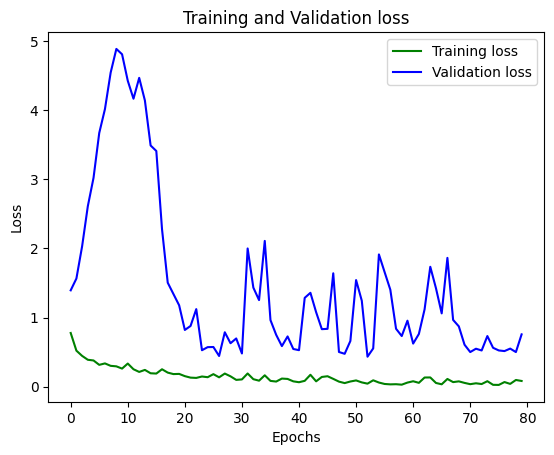

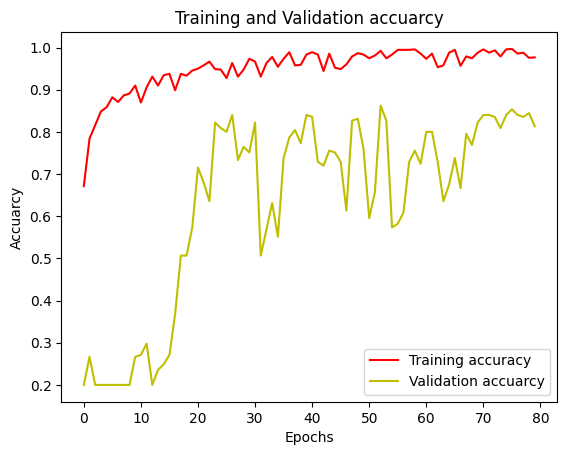


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       240
           1       0.90      0.99      0.94       169
           2       0.90      1.00      0.94       210
           3       0.99      1.00      1.00       279

    accuracy                           0.95       898
   macro avg       0.95      0.95      0.95       898
weighted avg       0.95      0.95      0.95       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
              precision    recall  f1-score   support

           0       0.84      0.53      0.65        60
           1       0.71      0.80      0.75        45
           2       0.71      0.95      0.82        42
           3       0.94      0.96      0.95        78

    accuracy                           0.81       225
   macro avg       0.80      0.81      0.79       225
weighted avg       0.82      0.81      0.81       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test,epoch=80)

## Third model

In [ ]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), dilation_rate=2),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu',strides=(2, 2), padding='valid'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='valid'),
    keras.layers.BatchNormalization(),
    AveragePooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax') #using softmax as activation function for the output layer
])
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_43 (Conv2D)                   │ (None, 180, 180, 11)        │           4,004 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 180, 180, 11)        │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_6                  │ (None, 90, 90, 11)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 43, 43, 11)          │           3,036 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 43, 43, 11)          │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 21, 21, 11)          │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 10, 10, 11)          │           1,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 10, 10, 11)          │              44 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_8                  │ (None, 5, 5, 11)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 275)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 100)                 │          27,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 4)                   │             404 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,376 (181.16 KB)

 Trainable params: 46,310 (180.90 KB)

 Non-trainable params: 66 (264.00 B)

### Compile

In [ ]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=80)

Epoch 1/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 14s 218ms/step - accuracy: 0.5990 - loss: 0.9903 - val_accuracy: 0.3511 - val_loss: 1.5241
Epoch 2/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - accuracy: 0.7376 - loss: 0.6579 - val_accuracy: 0.2667 - val_loss: 2.3167
Epoch 3/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.7817 - loss: 0.4864 - val_accuracy: 0.2267 - val_loss: 2.4128
Epoch 4/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7562 - loss: 0.5593 - val_accuracy: 0.2178 - val_loss: 4.5769
Epoch 5/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8252 - loss: 0.4357 - val_accuracy: 0.2000 - val_loss: 3.6752
Epoch 6/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8381 - loss: 0.4108 - val_accuracy: 0.2711 - val_loss: 2.9274
Epoch 7/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7781 - loss: 0.5421 - val_accuracy: 0.2000 - val_loss: 3.6508
Epoch 8/80
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8031 - loss: 0.5163 - val_accuracy: 0.4000 

### Report

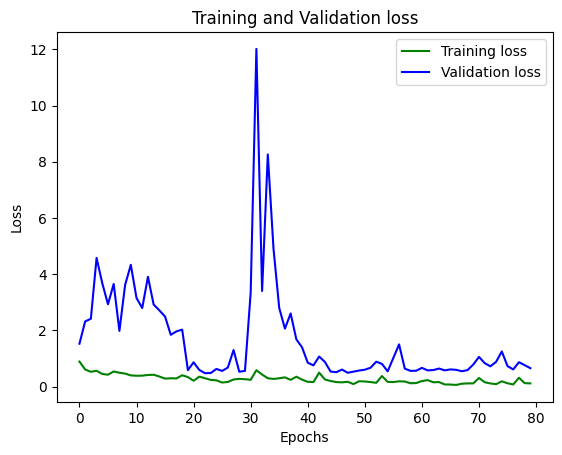

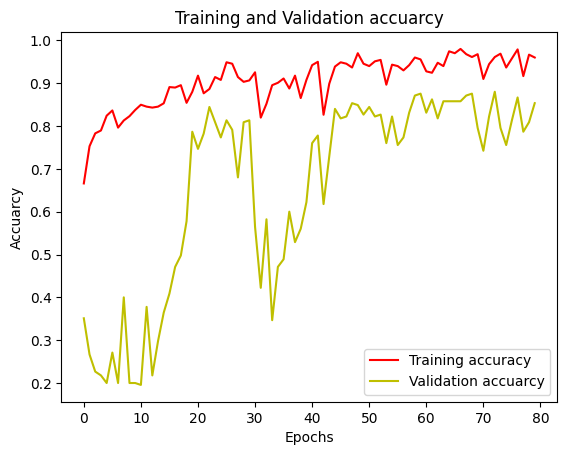


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       240
           1       0.99      1.00      0.99       169
           2       0.99      1.00      0.99       210
           3       1.00      1.00      1.00       279

    accuracy                           0.99       898
   macro avg       0.99      0.99      0.99       898
weighted avg       0.99      0.99      0.99       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
              precision    recall  f1-score   support

           0       0.82      0.70      0.76        60
           1       0.73      0.80      0.77        45
           2       0.80      0.88      0.84        42
           3       0.97      0.99      0.98        78

    accuracy                           0.85       225
   macro avg       0.83      0.84      0.84       225
weighted avg       0.85      0.85      0.85       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test,epoch=80)

# *RESNET*

## Identity Block Function

In [ ]:
def identity_block(X, f, filters, training=True, initializer=random_uniform):
  F1, F2, F3 = filters  #using three filters
  X_shortcut = X
  cache = []
  X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
  X = BatchNormalization(axis = 3)(X, training = training) # Default axis
  X = Activation('relu')(X)
  X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
  X = BatchNormalization(axis = 3)(X, training=training)
  X = Activation('relu')(X)
  X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
  X = BatchNormalization(axis = 3)(X, training=training)
  X = Add()([X_shortcut,X])
  X = Activation('relu')(X)
  return X

## Convolutional Block Function

In [ ]:
def convolutional_block(X, f, filters, s = 2, training=True, initializer=glorot_uniform):
  F1, F2, F3 = filters
  X_shortcut = X
  X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
  X = BatchNormalization(axis = 3)(X, training=training)
  X = Activation('relu')(X)
  X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
  X = BatchNormalization(axis = 3)(X, training=training)
  X = Activation('relu')(X)
  X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
  X = BatchNormalization(axis = 3)(X, training=training)
  X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = 3)(X_shortcut, training=training)
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)
  return X

## Build Model

In [ ]:
def ResNet50(input_shape = (200, 200, 3), classes = 4):

  X_input = Input(input_shape)
  X = ZeroPadding2D((3, 3))(X_input)
  X = Conv2D(200, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3)(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)
  X = convolutional_block(X, f = 3, filters = [64, 64, 64], s = 1)
  X = identity_block(X, 3, [64, 64, 64])
  X = identity_block(X, 3, [64, 64, 64])
  X = convolutional_block(X, f = 3, filters = [128,128,128], s = 2)
  X = identity_block(X, 3,  [128,128,128])
  X = identity_block(X, 3,  [128,128,128])
  X = identity_block(X, 3,  [128,128,128])
  X = convolutional_block(X, f = 3, filters = [256, 256, 256], s = 2)
  X = identity_block(X, 3, [256, 256, 256])
  X = identity_block(X, 3, [256, 256, 256])
  X = identity_block(X, 3, [256, 256, 256])
  X = identity_block(X, 3, [256, 256, 256])
  X = identity_block(X, 3, [256, 256, 256])
  X = convolutional_block(X, f = 3, filters = [512, 512, 512], s = 2)
  X = identity_block(X, 3, [512, 512, 512])
  X = identity_block(X, 3, [512, 512, 512])
  X = AveragePooling2D((2, 2))(X)
  X = Flatten()(X)
  X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
  model = Model(inputs = X_input, outputs = X)

  return model

## Compile

In [ ]:
model = ResNet50(input_shape=(200,200,3),classes=4)
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 206, 206, 3)    │              0 │ input_layer_12[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 100, 100, 200)  │         29,600 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_19    │ (None, 100, 100, 200)  │            800 │ conv2d_46[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 100, 100, 200)  │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 49, 49, 200)    │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 49, 49, 64)     │         12,864 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_20    │ (None, 49, 49, 64)     │            256 │ conv2d_47[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 49, 49, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 49, 49, 64)     │         36,928 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_21    │ (None, 49, 49, 64)     │            256 │ conv2d_48[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 49, 49, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 49, 49, 64)     │          4,160 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 49, 49, 64)     │         12,864 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 49, 49, 64)     │            256 │ conv2d_49[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 49, 49, 64)     │            256 │ conv2d_50[0][0]        │
│ (BatchNormalization) 

 Total params: 13,963,972 (53.27 MB)

 Trainable params: 13,938,996 (53.17 MB)

 Non-trainable params: 24,976 (97.56 KB)

In [ ]:
tf.debugging.set_log_device_placement(True)
with tf.device('/GPU:0'):
  history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_test, y_test))

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.4571 - loss: 3.3184 - val_accuracy: 0.2667 - val_loss: 1.8959
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.6642 - loss: 1.2040 - val_accuracy: 0.2000 - val_loss: 1.7186
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.7156 - loss: 0.9104 - val_accuracy: 0.2000 - val_loss: 2.9137
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.6962 - loss: 0.7965 - val_accuracy: 0.2000 - val_loss: 3.6075
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step - accuracy: 0.6932 - loss: 1.1385 - val_accuracy: 0.2000 - val_loss: 1.7755
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.8236 - loss: 0.4506 - val_accuracy: 0.2000 - val_loss: 2.8535
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 175ms/step - accuracy: 0.8142 - loss: 0.4647 - val_accuracy: 0.2667 - val_loss: 3.5442
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.7454 - loss: 0.7741 - val_accuracy: 0.1

## Report

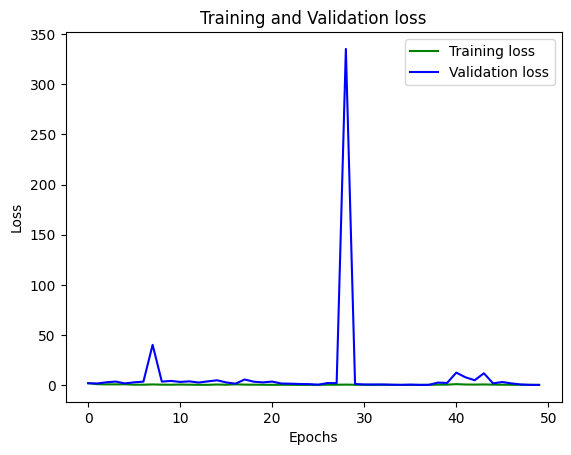

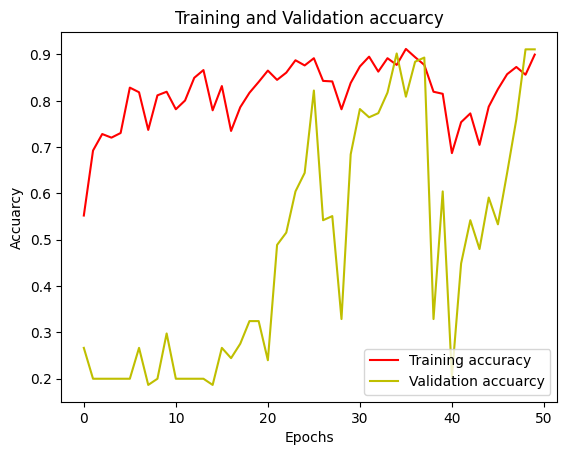


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 270ms/step
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       240
           1       0.84      0.90      0.87       169
           2       0.88      0.92      0.90       210
           3       0.98      0.99      0.98       279

    accuracy                           0.90       898
   macro avg       0.89      0.90      0.90       898
weighted avg       0.90      0.90      0.90       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 562ms/step
              precision    recall  f1-score   support

           0       0.91      0.80      0.85        60
           1       0.83      0.89      0.86        45
           2       0.85      0.95      0.90        42
           3       1.00      0.99      0.99        78

    accuracy                           0.91       225
   macro avg       0.90      0.91      0.90       225
weighted avg       0.91      0.91      0.91       225



In [ ]:
report(history, model, X_train, X_test, y_train, y_test)

# *Inception*

## Inception module

In [ ]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):

    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

    return output

In [ ]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.2)

In [ ]:
input_layer = Input(shape=(200, 200, 3))

# Change the name to remove the forward slash '/'
x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7_2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3_2')(x)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3_2')(x)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3_2')(x)
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3_2')(x)
x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')



# Changed the name to 'max_pool_5_3x3_2' to avoid conflict
x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3_2_first')(x)



x1 = AveragePooling2D((3, 3), strides=2)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(4, activation='softmax', name='auxilliary_output_1')(x1)




x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((3, 3), strides=2)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(4, activation='softmax', name='auxilliary_output_2')(x2)
x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPooling2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3_2_second')(x)

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3_1')(x)
x = Dropout(0.4)(x)

x = Dense(4, activation='softmax', name='output')(x)

In [ ]:
model = Model(input_layer, [x, x1, x2], name='inception_v1')
# Verify all layer names are unique before this line

In [ ]:
model.summary()

Model: "inception_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22            │ (None, 200, 200, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_1_7x7_2 (Conv2D)     │ (None, 100, 100, 64)   │          9,472 │ input_layer_22[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_1_3x3_2          │ (None, 50, 50, 64)     │              0 │ conv_1_7x7_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_2_3x3_2          │ (None, 25, 25, 64)     │              0 │ max_pool_1_3x3_2[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_3_3x3_2          │ (None, 13, 13, 64)     │              0 │ max_pool_2_3x3_2[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_4_3x3_2          │ (None, 7, 7, 64)       │              0 │ max_pool_3_3x3_2[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_256 (Conv2D)       │ (None, 7, 7, 96)       │          6,240 │ max_pool_4_3x3_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_258 (Conv2D)       │ (None, 7, 7, 16)       │          1,040 │ max_pool_4_3x3_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_31          │ (None, 7, 7, 64)       │              0 │ max_pool_4_3x3_2[0][0] │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_255 (Conv2D)       │ (None, 7, 7, 64)       │          4,160 │ max_pool_4_3x3_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_257 (Conv2D)       │ (None, 7, 7, 128)      │        110,720 │ conv2d_256[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_259 (Conv2D)       │ (None, 7, 7, 32)       │         12,832 │ conv2d_258[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_260 (Conv2D)       │ (None, 7, 7, 32)       │          2,080 │ max_pooling2d_31[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_3a              │ (None, 7, 7, 256)      │              0 │ conv2d_255[0][0],      │
│ (Concatenate)             │                        │                │ conv2d_257[0][0],      │
│                           │                        │                │ conv2d_259[0][0],      │
│                           │                        │                │ conv2d_260[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pool_4_3x3_2_first    │ (None, 4, 4, 256)      │              0 │ inception_3a[0][0]     │
│ (MaxPooling2D)       

 Total params: 3,351,340 (12.78 MB)

 Trainable params: 3,351,340 (12.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=opt,
    loss=[tf.keras.losses.CategoricalCrossentropy()]*3,
    metrics=[['accuracy'], ['accuracy'], ['accuracy']]
)

# Training
with tf.device('/GPU:0'):
  history = model.fit(
      X_train, [y_train, y_train, y_train],  # Match the 3 outputs
      validation_data=(X_test, [y_test, y_test, y_test]),  # Validate on 3 outputs
      epochs=50
  )

Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 46s 795ms/step - auxilliary_output_1_accuracy: 0.2789 - auxilliary_output_1_loss: 1.3875 - auxilliary_output_2_accuracy: 0.2901 - auxilliary_output_2_loss: 1.3847 - loss: 5.0995 - output_accuracy: 0.2682 - output_loss: 2.3295 - val_auxilliary_output_1_accuracy: 0.3467 - val_auxilliary_output_1_loss: 1.3479 - val_auxilliary_output_2_accuracy: 0.3467 - val_auxilliary_output_2_loss: 1.3518 - val_loss: 4.0989 - val_output_accuracy: 0.2667 - val_output_loss: 1.3424
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - auxilliary_output_1_accuracy: 0.2900 - auxilliary_output_1_loss: 1.3843 - auxilliary_output_2_accuracy: 0.2960 - auxilliary_output_2_loss: 1.3903 - loss: 4.2213 - output_accuracy: 0.2541 - output_loss: 1.4461 - val_auxilliary_output_1_accuracy: 0.3467 - val_auxilliary_output_1_loss: 1.3555 - val_auxilliary_output_2_accuracy: 0.3467 - val_auxilliary_output_2_loss: 1.3656 - val_loss: 4.1465 - val_output_accuracy: 0.1867 - val_output_loss: 1.3

In [ ]:
print(history.history.keys())
print()
plot_model(model, show_shapes=True, to_file='vgg_block.png')

dict_keys(['auxilliary_output_1_accuracy', 'auxilliary_output_1_loss', 'auxilliary_output_2_accuracy', 'auxilliary_output_2_loss', 'loss', 'output_accuracy', 'output_loss', 'val_auxilliary_output_1_accuracy', 'val_auxilliary_output_1_loss', 'val_auxilliary_output_2_accuracy', 'val_auxilliary_output_2_loss', 'val_loss', 'val_output_accuracy', 'val_output_loss'])



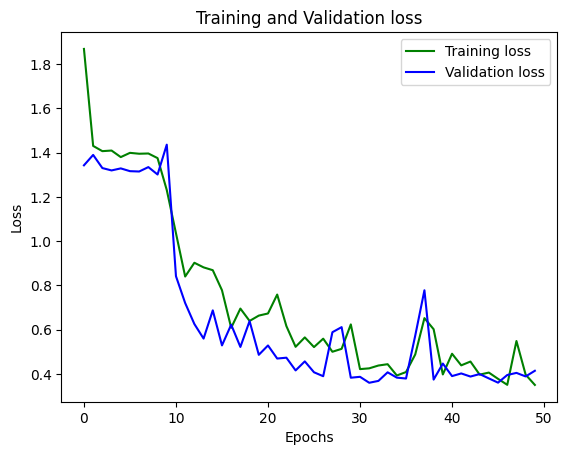

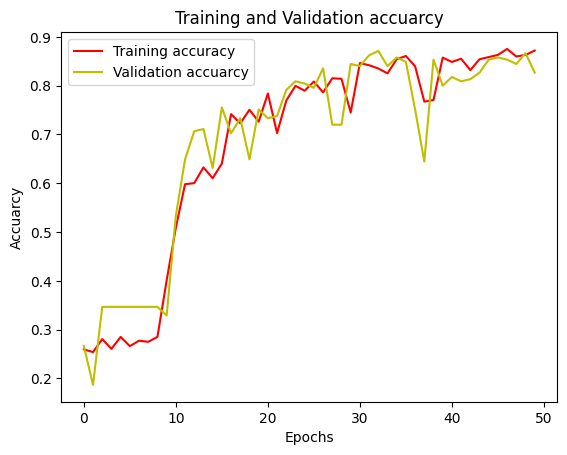


Train report
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       240
           1       0.84      0.64      0.73       169
           2       0.76      0.96      0.84       210
           3       0.98      0.94      0.96       279

    accuracy                           0.83       898
   macro avg       0.83      0.81      0.81       898
weighted avg       0.83      0.83      0.83       898



test report
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step
              precision    recall  f1-score   support

           0       0.69      0.63      0.66        60
           1       0.78      0.62      0.69        45
           2       0.70      0.95      0.81        42
           3       1.00      0.99      0.99        78

    accuracy                           0.81       225
   macro avg       0.79      0.80      0.79       225
weighted avg       0.82      0.81      0.81       225



In [ ]:
report_inc(history, model, X_train, X_test, y_train, y_test)

# *K fold*


## First model

In [ ]:
# model with 6 layers
# concat both inputs of train and test
inputs = np.concatenate((X_train, X_test), axis=0)

# concat both outputs of train and test
outputs = np.concatenate((y_train, y_test), axis=0)
accuracy_per_fold = []
loss_per_fold = []

  # create kfold with k = 5
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_number = 1
for train, test in kfold.split(inputs, outputs):

  model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')
])
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
  # train the model
  with tf.device('/GPU:0'):
    history = model.fit(inputs[train], outputs[train],epochs=50)

  # compute score of the model (loss and accuracy)
  scores = model.evaluate(inputs[test], outputs[test], verbose=0)
  print()
  print(f'Score for fold {fold_number}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  print()
  Confusion(model, inputs[train], inputs[test], outputs[train], outputs[test])

  # draw the confusion matrix
  #f1(model, inputs[train], inputs[test], outputs[train], outputs[test])

  # append accuracy and loss of each fold
  accuracy_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_number = fold_number + 1

print('Average scores for all folds:')

# calculate mean of all accuracies
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')

# calculate mean of all losses
print(f'> Loss: {np.mean(loss_per_fold)}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.6088 - loss: 0.9141
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.8454 - loss: 0.4219
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.8858 - loss: 0.3243
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8862 - loss: 0.3229
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8579 - loss: 0.4346
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8983 - loss: 0.2313
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9154 - loss: 0.2161
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9358 - loss: 0.1562
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9558 - loss: 0.1404
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9289 - loss: 0.1680
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9476 - loss: 0.1313
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.6343 - loss: 0.8903
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8054 - loss: 0.4630
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8487 - loss: 0.3615
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8788 - loss: 0.3038
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9338 - loss: 0.2046
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8903 - loss: 0.2708
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8448 - loss: 0.4201
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9455 - loss: 0.1776
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9521 - loss: 0.1409
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9162 - loss: 0.2512
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9578 - loss: 0.1314
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.5929 - loss: 0.9986
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8532 - loss: 0.4515
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8899 - loss: 0.3261
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9055 - loss: 0.2562
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9177 - loss: 0.2261
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9087 - loss: 0.2980
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8770 - loss: 0.3350
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9301 - loss: 0.2064
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9701 - loss: 0.0780
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9858 - loss: 0.0502
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9711 - loss: 0.0989
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 0.6184 - loss: 0.8789
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8284 - loss: 0.4165
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8670 - loss: 0.4107
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9104 - loss: 0.2751
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9312 - loss: 0.1805
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9352 - loss: 0.1709
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8909 - loss: 0.3076
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9057 - loss: 0.2263
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9574 - loss: 0.1218
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9187 - loss: 0.2058
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9639 - loss: 0.1130
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.5574 - loss: 1.0764
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8431 - loss: 0.4095
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8697 - loss: 0.3269
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8799 - loss: 0.3402
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8852 - loss: 0.3145
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9133 - loss: 0.2118
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9278 - loss: 0.2128
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9302 - loss: 0.1797
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9605 - loss: 0.1069
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9773 - loss: 0.0813
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9399 - loss: 0.1773
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy

## Second model

In [ ]:
# model with 6 layers
# concat both inputs of train and test
inputs = np.concatenate((X_train, X_test), axis=0)

# concat both outputs of train and test
outputs = np.concatenate((y_train, y_test), axis=0)
accuracy_per_fold = []
loss_per_fold = []

  # create kfold with k = 5
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_number = 1
for train, test in kfold.split(inputs, outputs):

  model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=11, kernel_size=(11,11),
                           activation='relu',
                           input_shape=(200,200,3), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3),strides=(2, 2)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(5,5),
                           activation='relu'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=11, kernel_size=(3,3),
                           activation='relu',strides=(2, 2), padding='same'),
    keras.layers.BatchNormalization(),
    MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150,activation='relu'),
    tf.keras.layers.Dense(150,activation='relu'),
    tf.keras.layers.Dense(4,activation='softmax')
])
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
  # train the model
  with tf.device('/GPU:0'):
    history = model.fit(inputs[train], outputs[train],epochs=50)

  # compute score of the model (loss and accuracy)
  scores = model.evaluate(inputs[test], outputs[test], verbose=0)
  print()
  print(f'Score for fold {fold_number}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  print()
  Confusion(model, inputs[train], inputs[test], outputs[train], outputs[test])

  # draw the confusion matrix
  #f1(model, inputs[train], inputs[test], outputs[train], outputs[test])

  # append accuracy and loss of each fold
  accuracy_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_number = fold_number + 1

print('Average scores for all folds:')

# calculate mean of all accuracies
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')

# calculate mean of all losses
print(f'> Loss: {np.mean(loss_per_fold)}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.5722 - loss: 1.1301
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.8222 - loss: 0.4928
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8012 - loss: 0.4360
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8720 - loss: 0.3453
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8845 - loss: 0.3154
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9215 - loss: 0.2066
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9477 - loss: 0.1380
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9202 - loss: 0.2146
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9571 - loss: 0.1464
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9425 - loss: 0.1488
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9567 - loss: 0.1402
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accurac

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.5841 - loss: 0.9881
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8079 - loss: 0.5085
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8747 - loss: 0.3178
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8685 - loss: 0.3412
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8770 - loss: 0.3027
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9252 - loss: 0.2228
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9131 - loss: 0.2409
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8897 - loss: 0.3270
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9389 - loss: 0.1738
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9287 - loss: 0.2246
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9001 - loss: 0.2660
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.5776 - loss: 1.0228
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7695 - loss: 0.5588
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8061 - loss: 0.4628
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8584 - loss: 0.3387
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9230 - loss: 0.2261
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9380 - loss: 0.1972
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9309 - loss: 0.2106
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9194 - loss: 0.2148
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9510 - loss: 0.1486
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9566 - loss: 0.1101
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.9220 - loss: 0.2122
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.6090 - loss: 0.9788
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8602 - loss: 0.3674
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8827 - loss: 0.3186
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8798 - loss: 0.3053
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9310 - loss: 0.1848
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9433 - loss: 0.1693
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9637 - loss: 0.1231
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9668 - loss: 0.0943
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9530 - loss: 0.1635
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8793 - loss: 0.3458
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9418 - loss: 0.1693
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.6401 - loss: 0.9281
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8045 - loss: 0.4935
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8204 - loss: 0.4255
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9218 - loss: 0.2400
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9457 - loss: 0.1794
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9048 - loss: 0.2591
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9191 - loss: 0.2170
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9366 - loss: 0.1974
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9369 - loss: 0.1496
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9710 - loss: 0.0914
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9606 - loss: 0.0934
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy:

## Third model

In [ ]:
# model with 6 layers
# concat both inputs of train and test
inputs = np.concatenate((X_train, X_test), axis=0)

# concat both outputs of train and test
outputs = np.concatenate((y_train, y_test), axis=0)
accuracy_per_fold = []
loss_per_fold = []

  # create kfold with k = 5
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_number = 1
for train, test in kfold.split(inputs, outputs):
  model = ResNet50(input_shape=(200,200,3),classes=4)
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer = opt, loss= tf.keras.losses.CategoricalCrossentropy() ,metrics=['accuracy'])
  # train the model
  with tf.device('/GPU:0'):
    history = model.fit(inputs[train], outputs[train],epochs=50)

  # compute score of the model (loss and accuracy)
  scores = model.evaluate(inputs[test], outputs[test], verbose=0)
  print()
  print(f'Score for fold {fold_number}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  print()
  Confusion(model, inputs[train], inputs[test], outputs[train], outputs[test])

  # draw the confusion matrix
  #f1(model, inputs[train], inputs[test], outputs[train], outputs[test])

  # append accuracy and loss of each fold
  accuracy_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_number = fold_number + 1

print('Average scores for all folds:')

# calculate mean of all accuracies
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')

# calculate mean of all losses
print(f'> Loss: {np.mean(loss_per_fold)}')

Epoch 1/50
29/29 [==============================] - 11s 189ms/step - loss: 1.3520 - accuracy: 0.6125
Epoch 2/50
29/29 [==============================] - 5s 172ms/step - loss: 0.6654 - accuracy: 0.7305
Epoch 3/50
29/29 [==============================] - 5s 172ms/step - loss: 0.8886 - accuracy: 0.7149
Epoch 4/50
29/29 [==============================] - 5s 172ms/step - loss: 0.5964 - accuracy: 0.8051
Epoch 5/50
29/29 [==============================] - 5s 172ms/step - loss: 0.9868 - accuracy: 0.7673
Epoch 6/50
29/29 [==============================] - 5s 173ms/step - loss: 0.6710 - accuracy: 0.7962
Epoch 7/50
29/29 [==============================] - 5s 173ms/step - loss: 0.4035 - accuracy: 0.8430
Epoch 8/50
29/29 [==============================] - 5s 174ms/step - loss: 0.5873 - accuracy: 0.8196
Epoch 9/50
29/29 [==============================] - 5s 174ms/step - loss: 0.5893 - accuracy: 0.7639
Epoch 10/50
29/29 [==============================] - 5s 174ms/step - loss: 0.5248 - accuracy: 0.790

# *Transfer Learning*

In [ ]:
base_model = tf.keras.applications.InceptionV3(input_shape=(200,200,3),
                                               include_top=False,
                                               weights = "imagenet"
                                               )

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
model_inc = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation="softmax")
])

model_inc.compile(loss='categorical_crossentropy' , optimizer=tf.keras.optimizers.Adam(lr = 0.001) , metrics='accuracy')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model_inc.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 2, 2, 2048)       0         
 g2D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 8192)              0         
                                                                 
 dense_16 (Dense)            (None, 4)                 32772     
                                                                 
Total params: 21,835,556
Trainable params: 32,772
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
hist_inc = model_inc.fit(X_train ,
          y_train ,
          epochs = 15 ,
          steps_per_epoch = 898/32, # train_files/batch_size
          validation_steps = 225/32, # valid_files/batch_size
          )

Epoch 1/15
28/28 [==============================] - 7s 85ms/step - loss: 1.3255 - accuracy: 0.3508
Epoch 2/15
28/28 [==============================] - 2s 60ms/step - loss: 1.0938 - accuracy: 0.5234
Epoch 3/15
28/28 [==============================] - 2s 60ms/step - loss: 1.0631 - accuracy: 0.5479
Epoch 4/15
28/28 [==============================] - 2s 61ms/step - loss: 0.8959 - accuracy: 0.6938
Epoch 5/15
28/28 [==============================] - 2s 61ms/step - loss: 0.8473 - accuracy: 0.7261
Epoch 6/15
28/28 [==============================] - 2s 60ms/step - loss: 0.8523 - accuracy: 0.6559
Epoch 7/15
28/28 [==============================] - 2s 60ms/step - loss: 0.8143 - accuracy: 0.7094
Epoch 8/15
28/28 [==============================] - 2s 61ms/step - loss: 0.7737 - accuracy: 0.7105
Epoch 9/15
28/28 [==============================] - 2s 60ms/step - loss: 0.7036 - accuracy: 0.7517
Epoch 10/15
28/28 [==============================] - 2s 61ms/step - loss: 0.7136 - accuracy: 0.7550
Epoch 11/